# <p style="text-align: center; color: #1E90FF; font-size: 25px;">Evaluating the Impact of Amazon Prime Day on Stock Performance Using Statistical and Causal Inference Methods</p>

### Table of Contents
* [1. Prime Day Data](#1)

* [2. Data Engineering](#2)

* [3. Merging Prime and Amazon Stock Data](#3)


* [4. Is there a statistically signifiant difference between Prime Day stock performance and non-prime day stock performance?](#3)

    * [4.1 Two-Tailed Welch T Test](#41)

    * [4.2 Match non-prime day data cocunt with prime day to eliminate sample imbalance and then perform T test](#42)

    * [4.3 Run the match 1000 times and average the T Statistics and P Value (Permutation Matching)](#43)

    * [4.4 Bootstrapping](#44)

    * [4.5 Propensity Score Matching](#45)
    

In [152]:
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind

# For Propensity Score Matching
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_columns', None)

In [153]:
df_stock = pd.read_csv("/Users/fengli/Documents/project_1/Data Science Projects/Amazon Stock Price vs. Prime Day/stock_amz.csv")
df_prime = pd.read_csv("/Users/fengli/Documents/project_1/Data Science Projects/Amazon Stock Price vs. Prime Day/prime_day.csv")

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=1>1. Prime Day Data</h1>
</div>

In [154]:
df_prime.head(2)

,year,start_date,start_datetime,end_datetime,duration_hr
0,2015,2015-07-15,2015-07-15 00:00:00,2015-07-16 00:00:00,24.0
1,2016,2016-07-12,2016-07-12 00:00:00,2016-07-13 00:00:00,24.0


In [155]:
# Rename columms by appending "prime_" to the begining of each column name in preparation of data merge later on.
df_prime.columns = ["prime_" + col for col in df_prime.columns]

In [156]:
# Check data type of each column
df_prime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prime_year            24 non-null     int64  
 1   prime_start_date      24 non-null     object 
 2   prime_start_datetime  24 non-null     object 
 3   prime_end_datetime    24 non-null     object 
 4   prime_duration_hr     24 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ KB


In [157]:
# Convert dates to datetime
cols = ["prime_start_date", "prime_start_datetime", "prime_end_datetime"]
df_prime[cols] = df_prime[cols].apply(pd.to_datetime)

In [158]:
df_prime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   prime_year            24 non-null     int64         
 1   prime_start_date      24 non-null     datetime64[ns]
 2   prime_start_datetime  24 non-null     datetime64[ns]
 3   prime_end_datetime    24 non-null     datetime64[ns]
 4   prime_duration_hr     24 non-null     float64       
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 1.1 KB


In [159]:
# Sort the dataset by `prime_start_datetime` ascending
df_prime = df_prime.sort_values(by = "prime_start_datetime", ascending = True)

In [160]:
df_prime.head()

,prime_year,prime_start_date,prime_start_datetime,prime_end_datetime,prime_duration_hr
0,2015,2015-07-15,2015-07-15,2015-07-16 00:00:00,24.0
1,2016,2016-07-12,2016-07-12,2016-07-13 00:00:00,24.0
2,2017,2017-07-11,2017-07-11,2017-07-12 00:00:00,24.0
3,2017,2017-07-12,2017-07-12,2017-07-12 06:00:00,6.0
4,2018,2018-07-16,2018-07-16,2018-07-17 00:00:00,24.0


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=2>2. Amazon Stock Data</h1>
</div>

Preprocessing df_stock

In [105]:
df_stock.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,06/24/2025,212.77,212.13,214.34,211.04,38.38M,2.06%
1,06/23/2025,208.47,209.79,210.39,207.31,37.31M,-0.58%


2.1 Rename columms by appending "stock_" to the begining of each column name in preparation of data merge later on.

In [106]:
df_stock.columns = ["stock_" + col for col in df_stock.columns]
df_stock.head(2)

,stock_Date,stock_Price,stock_Open,stock_High,stock_Low,stock_Vol.,stock_Change %
0,06/24/2025,212.77,212.13,214.34,211.04,38.38M,2.06%
1,06/23/2025,208.47,209.79,210.39,207.31,37.31M,-0.58%


In [107]:
df_stock["stock_Date"] = pd.to_datetime(df_stock["stock_Date"]).dt.strftime('%Y-%m-%d')
df_stock["stock_Date"] = pd.to_datetime(df_stock["stock_Date"])

In [108]:
df_stock = df_stock.rename(columns = {"stock_Change %":"stock_Change_%",})
df_stock["stock_Change_%"] = df_stock["stock_Change_%"].str.rstrip("%").astype("float")             

In [109]:
df_stock["Prime_day"] = df_stock["stock_Date"].isin(df_prime["prime_start_date"])

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=3>3. Merge Prime and Stock data</h1>
</div>

In [110]:
df_merged = df_prime.merge(df_stock, how = "right", left_on = "prime_start_date", right_on = "stock_Date")
df_merged.shape

(3892, 13)

In [111]:
df_merged.head()

,prime_year,prime_start_date,prime_start_datetime,prime_end_datetime,prime_duration_hr,stock_Date,stock_Price,stock_Open,stock_High,stock_Low,stock_Vol.,stock_Change_%,Prime_day
0,NaN,NaT,NaT,NaT,NaN,2025-06-24,212.77,212.13,214.34,211.04,38.38M,2.06,False
1,NaN,NaT,NaT,NaT,NaN,2025-06-23,208.47,209.79,210.39,207.31,37.31M,-0.58,False
2,NaN,NaT,NaT,NaT,NaN,2025-06-20,209.69,214.68,214.89,208.27,75.35M,-1.33,False
3,NaN,NaT,NaT,NaT,NaN,2025-06-18,212.52,215.09,217.96,212.34,44.36M,-1.07,False
4,NaN,NaT,NaT,NaT,NaN,2025-06-17,214.82,215.20,217.41,214.56,32.09M,-0.59,False


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=4>4. Is there a statistically signifiant difference between Prime Day stock performance and non-prime day stock performance?</h1>
</div>

Null hypothesis: There is no difference in `Change_%` between Prime Days and non-Prime Days.

Alternative hypothesis: There is a difference in `Change_%`between the two.

Significance Level: 0.05

In [112]:
prime = df_merged[df_merged["Prime_day"]]["stock_Change_%"].dropna()
nonprime = df_merged[~df_merged["Prime_day"]]["stock_Change_%"].dropna()

In [113]:
print(prime.mean())
print(nonprime.mean())

-0.19736842105263164
0.11168861347792408


<h4 id="41">📊 Option 1: Two-Tail Welch T Test</h4>

In [114]:
t_stat, p_val = ttest_ind(prime, nonprime, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

T-statistic: -0.956, P-value: 0.3516


The Welch's T Test indicates that the mean stock return on Prime Days in 0.956 standard errors lower than the mean on non-Prime days. It is a small difference and the P value is greater than our significance level, I fail to reject the null hypothesis. 

However, with 19 prime days and over 3000 non prime days, statitical power is low, which means a true effect might go undetected unless the sample size of prime day is also large enough (19 is on the edge of small). So even though Welch T test is adjusted to address the unequal variances and sample sizes between groups, the test may still fail to detect it because there is not enough data (low power).

We failed our first statistical test IN TERMS OF what we expect to proof in mind.

<h4 id="42">📊 Option 2: Match non-prime day data cocunt with prime day to eliminate sample imbalance and then perform T test.</h4>

In [115]:
nonprime_matched = nonprime.sample(n=19, random_state=42)
t_stat, p_val = ttest_ind(prime, nonprime_matched, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

T-statistic: -2.613, P-value: 0.0132


The average prime day stock return is 2.613 standard error lower than on non Prime days with a p value of 0.0132, indicating that this result is statistically significant.

However, I randomly selected only 19 sample from total of 3000+ non Prime days, next step, I will run match 1000 times and average both the t statistic and p value to compare the result.

This could be due to the following reasons:

1. Before Prime day, investors might get excited buying Amazon stock in anticipation of strong performance, and once Prime day arrives, some invesstors sell to lock in profits. The stock prime may drop at the end of the day, even if the event itself is successful.

2. Traders often buy stocks weeks or days before an expected positive event, and by the time Prime day actually arrives, the expected gains are already priced into the stock.

3. Other macro factors: such as interest rate, inflation, geopolitical events, which means, even if Prime Day is a success, overall market negativity can drag the stock down.

<h4 id="43">📊 Option 3: Run the match 1000 times and average the T Statistics and P Value (Permutation Matching) </h4>

In [116]:
# Convert pandas series to NumPy array, which is much faster for operations like random sampling or math computation.
prime_arr = prime.values
nonprime_arr = nonprime.values

t_values = []
p_values = []

np.random.seed(42)

for _ in range(1000):
    sampled_nonprime = np.random.choice(nonprime_arr, size=len(prime_arr), replace = True)

    t_stat, p_val = ttest_ind(prime_arr, sampled_nonprime, equal_var = False)

    t_values.append(t_stat)
    p_values.append(p_val)

avg_t = np.mean(t_values)
avg_p = np.mean(p_values)

print("Average T Statistics:", avg_t)
print("Average P Value:", avg_p)

Average T Statistics: -0.553857701705394
Average P Value: 0.49803206249726806


Across many random matches, there is no consistent evidence that Prime day returns differ meaningfully from non prime days.

<h4 id="44">📊 Option 4: Bootstrapping </h4>

In [117]:
diffs = []
for _ in range(1000):
    boot_prime = np.random.choice(prime, size=len(prime), replace=True)
    boot_nonprime = np.random.choice(nonprime, size=len(nonprime), replace=True)
    diff = np.mean(boot_prime) - np.mean(boot_nonprime)
    diffs.append(diff)

# Compute 95% confidence interval
lower, upper = np.percentile(diffs, [2.5, 97.5])
print(f"95% CI of mean difference: ({lower:.4f}, {upper:.4f})")

95% CI of mean difference: (-0.9239, 0.2941)


We are 95% confident that the true mean difference (Prime - non-Prime) lies somewhere between -0.9952 and 0.2885. Since 0 is within the interval, the difference is not statistically significant at the 95% level.

<h4 id="45">📊 Option 5: Propensity Score Matching </h4>

In [118]:
df_propensity = df_merged.copy()

In [119]:
print(df_propensity.stock_Date.min())
print(df_propensity.stock_Date.max())

print("First Prime Day")
first_prime_day = df_propensity.loc[df_propensity["Prime_day"]==True, "stock_Date"].min()
print(first_prime_day)

2010-01-04 00:00:00
2025-06-24 00:00:00
First Prime Day
2015-07-15 00:00:00


Collect and process covariates that determines propensity score
1. Days of week
2. Month
3. Trading Volume
4. Market Return
5. Five Day Market Return Trend
6. Interest Rate
7. Inflation

In [120]:
# Days of week: Stocks behave differently on Mondays vs Fridays
df_propensity["Days_of_week"] = df_propensity["stock_Date"].dt.weekday
# Month
df_propensity["Month"] = df_propensity["stock_Date"].dt.month

In [121]:
# Market return, trading volume
sp500 = pd.read_csv("/Users/fengli/Documents/project_1/Data Science Projects/Amazon Stock Price vs. Prime Day/sp500.csv")
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


In [122]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23323 non-null  object 
 1   Open       23323 non-null  float64
 2   High       23323 non-null  float64
 3   Low        23323 non-null  float64
 4   Close      23323 non-null  float64
 5   Adj Close  23323 non-null  float64
 6   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


In [123]:
# Rename all columns
sp500.columns = ["sp500_" + col for col in sp500.columns]

sp500["sp500_Date"] = pd.to_datetime(sp500["sp500_Date"])
sp500 = sp500.sort_values(by = "sp500_Date")

sp500 = sp500[
    (sp500['sp500_Date'] >= df_propensity['stock_Date'].min()) &
    (sp500['sp500_Date'] <= df_propensity['stock_Date'].max())
]

In [124]:
print(df_propensity["stock_Date"].duplicated().any())
print(sp500["sp500_Date"].duplicated().any())

sp500 = sp500.rename(columns={"sp500_Date": "stock_Date"})
propensity_merged = df_propensity.merge(sp500, on="stock_Date", how="inner")

False
False


In [125]:
propensity_merged.head(3)

,prime_year,prime_start_date,prime_start_datetime,prime_end_datetime,prime_duration_hr,stock_Date,stock_Price,stock_Open,stock_High,stock_Low,stock_Vol.,stock_Change_%,Prime_day,Days_of_week,Month,sp500_Open,sp500_High,sp500_Low,sp500_Close,sp500_Adj Close,sp500_Volume
0,NaN,NaT,NaT,NaT,NaN,2020-11-04,162.06,158.00,162.24,156.99,136.78M,6.32,False,2,11,3406.459961,3486.250000,3405.169922,3443.439941,3443.439941,4783040000
1,NaN,NaT,NaT,NaT,NaN,2020-11-03,152.42,150.93,153.75,149.05,97.96M,1.46,False,1,11,3336.250000,3389.489990,3336.250000,3369.159912,3369.159912,4220070000
2,NaN,NaT,NaT,NaT,NaN,2020-11-02,150.22,153.09,153.99,147.51,145.15M,-1.05,False,0,11,3296.199951,3330.139893,3279.739990,3310.239990,3310.239990,4310590000


In [126]:
propensity_merged = propensity_merged.sort_values("stock_Date")
propensity_merged["sp500_Return"] = propensity_merged["sp500_Close"].pct_change()

In [ ]:
# Recent Market return trend prior to a specific Prime Day
propensity_merged["past_5day_sp500_return"] = (
    propensity_merged["sp500_Return"].rolling(5).sum().shift(1)
)

In [128]:
print(propensity_merged.stock_Date.min())
print(propensity_merged.stock_Date.max())

2010-01-04 00:00:00
2020-11-04 00:00:00


In [129]:
propensity_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2730 entries, 2729 to 0
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   prime_year              10 non-null     float64       
 1   prime_start_date        10 non-null     datetime64[ns]
 2   prime_start_datetime    10 non-null     datetime64[ns]
 3   prime_end_datetime      10 non-null     datetime64[ns]
 4   prime_duration_hr       10 non-null     float64       
 5   stock_Date              2730 non-null   datetime64[ns]
 6   stock_Price             2730 non-null   float64       
 7   stock_Open              2730 non-null   float64       
 8   stock_High              2730 non-null   float64       
 9   stock_Low               2730 non-null   float64       
 10  stock_Vol.              2730 non-null   object        
 11  stock_Change_%          2730 non-null   float64       
 12  Prime_day               2730 non-null   bool         

In [130]:
propensity_merged.head(2)

,prime_year,prime_start_date,prime_start_datetime,prime_end_datetime,prime_duration_hr,stock_Date,stock_Price,stock_Open,stock_High,stock_Low,stock_Vol.,stock_Change_%,Prime_day,Days_of_week,Month,sp500_Open,sp500_High,sp500_Low,sp500_Close,sp500_Adj Close,sp500_Volume,sp500_Return,past_5day_sp500_return
2729,NaN,NaT,NaT,NaT,NaN,2010-01-04,6.70,6.81,6.83,6.66,152.01M,-0.45,False,0,1,1116.560059,1133.869995,1116.560059,1132.98999,1132.98999,3991400000,NaN,NaN
2728,NaN,NaT,NaT,NaT,NaN,2010-01-05,6.73,6.67,6.77,6.59,177.13M,0.45,False,1,1,1132.660034,1136.630005,1129.660034,1136.52002,1136.52002,2491020000,0.003116,NaN


In [94]:
psm_df = propensity_merged.dropna(subset=['sp500_Return', 'past_5day_sp500_return', "Days_of_week", "Month"])
psm_df["Prime_day"] = psm_df["Prime_day"].astype(int)

treatment_col = "Prime_day"
covariates = ['sp500_Return', 'past_5day_sp500_return', 'Days_of_week', 'Month']

X = psm_df[covariates]
X = sm.add_constant(X)
y = psm_df[treatment_col]

logit = sm.Logit(y, X).fit()
psm_df['propensity_score'] = logit.predict(X)

treated = psm_df[psm_df[treatment_col] == 1]
control = psm_df[psm_df[treatment_col] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
_, indices = nn.kneighbors(treated[['propensity_score']])

matched_control = control.iloc[indices.flatten()].copy()
matched_treated = treated.reset_index(drop=True)

matched_df = pd.concat([matched_treated, matched_control])


treated_outcome = matched_treated['stock_Change_%']
control_outcome = matched_control['stock_Change_%']

effect = treated_outcome.mean() - control_outcome.mean()
print("Estimated treatment effect of Prime Day on stock change %:", effect)


Optimization terminated successfully.
         Current function value: 0.022609
         Iterations 11
Estimated treatment effect of Prime Day on stock change %: 0.43600000000000017


/var/folders/l1/_wpfw91x3_v1dkxzfb_546f40000gn/T/ipykernel_48067/1882198926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psm_df["Prime_day"] = psm_df["Prime_day"].astype(int)
/var/folders/l1/_wpfw91x3_v1dkxzfb_546f40000gn/T/ipykernel_48067/1882198926.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psm_df['propensity_score'] = logit.predict(X)


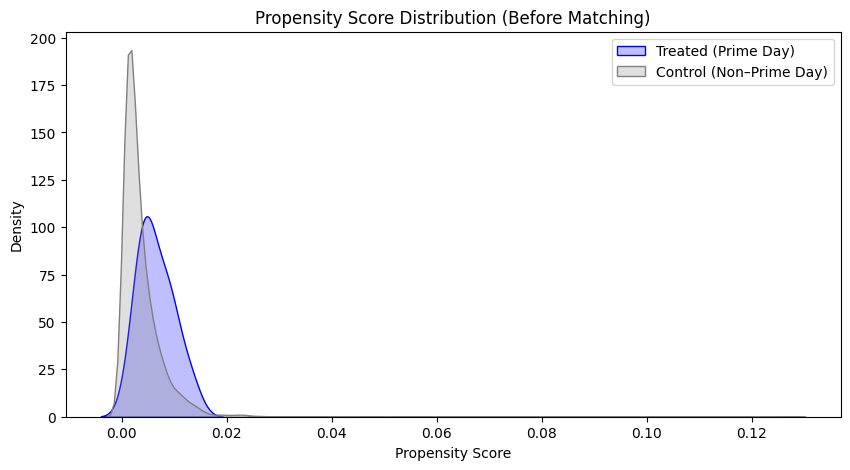

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before Matching
plt.figure(figsize=(10, 5))
sns.kdeplot(psm_df[psm_df["Prime_day"] == 1]["propensity_score"], label="Treated (Prime Day)", fill=True, color='blue')
sns.kdeplot(psm_df[psm_df["Prime_day"] == 0]["propensity_score"], label="Control (Non–Prime Day)", fill=True, color='gray')
plt.title("Propensity Score Distribution (Before Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()


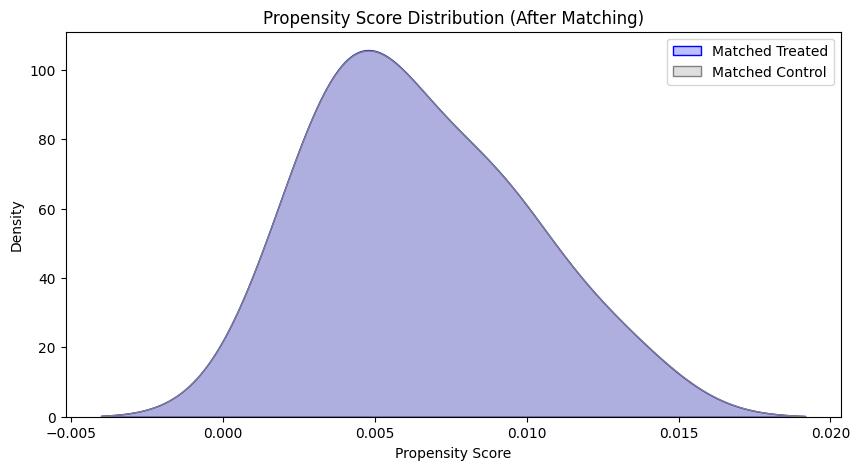

In [133]:
plt.figure(figsize=(10, 5))
sns.kdeplot(matched_treated["propensity_score"], label="Matched Treated", fill=True, color='blue')
sns.kdeplot(matched_control["propensity_score"], label="Matched Control", fill=True, color='gray')
plt.title("Propensity Score Distribution (After Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()


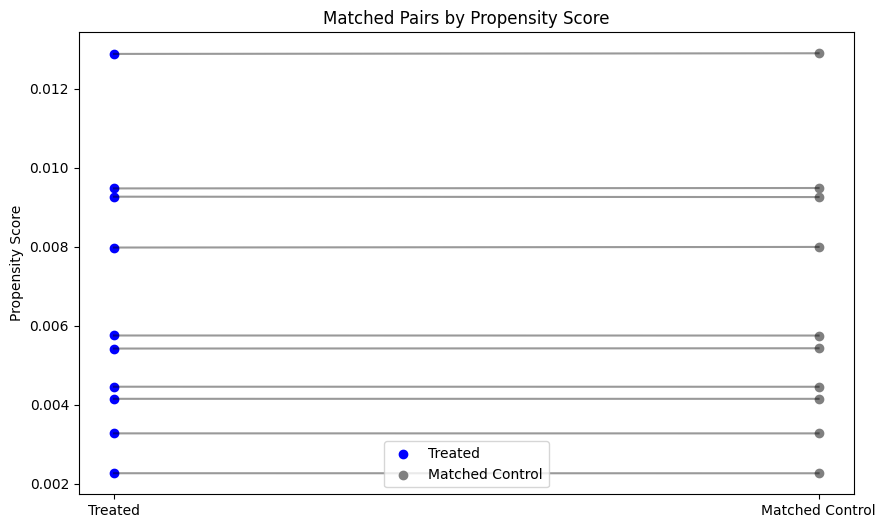

In [134]:
plt.figure(figsize=(10, 6))
for i in range(len(matched_treated)):
    plt.plot(
        [1, 2], 
        [matched_treated.iloc[i]["propensity_score"], matched_control.iloc[i]["propensity_score"]],
        'k-', alpha=0.4
    )

plt.scatter([1]*len(matched_treated), matched_treated["propensity_score"], color='blue', label='Treated')
plt.scatter([2]*len(matched_control), matched_control["propensity_score"], color='gray', label='Matched Control')
plt.xticks([1, 2], ['Treated', 'Matched Control'])
plt.title("Matched Pairs by Propensity Score")
plt.ylabel("Propensity Score")
plt.legend()
plt.show()


T test

In [138]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(treated_outcome, control_outcome)

print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: 0.7269220316667436
p-value: 0.4857505375258644


In [95]:
for col in covariates:
    print(f"{col}:")
    print("Treated mean:", matched_treated[col].mean())
    print("Control mean:", matched_control[col].mean())
    print()


sp500_Return:
Treated mean: -4.1517328997997535e-05
Control mean: -0.0011919918253731287

past_5day_sp500_return:
Treated mean: 0.015192914148855352
Control mean: 0.009564669556047112

Days_of_week:
Treated mean: 1.1
Control mean: 1.1

Month:
Treated mean: 7.6
Control mean: 8.9

